<a href="https://colab.research.google.com/github/Andresf-Asprilla/Modelo-segmentacion-APCIVMAPCAs/blob/main/Interfaz_Inferencias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# @title
from ipywidgets import TwoByTwoLayout, Button, GridspecLayout, VBox, HBox, Output, Layout
from requests_toolbelt.multipart.encoder import MultipartEncoder
from google.colab.output import serve_kernel_port_as_iframe
from IPython.display import display, HTML, clear_output
from google.colab import files, auth
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab._message import MessageError
from oauth2client.client import GoogleCredentials
from skimage import measure
from tqdm.notebook import tqdm
import ipywidgets as widgets
import contextlib
import zipfile
import subprocess
import tempfile
import threading
import requests
import random
import gdown
import time
import os
import sys
import logging
import re
import shutil
import glob
import sys


class Crear_Botones2:
  def __init__(self, description, button_style, operation_name, action_name=None, *args, width='auto', height='50px', file_temp=None):
    self.description=description
    self.button_style=button_style
    self.operation_name=operation_name
    self.args = args
    self.width =width
    self.height=height
    self.action_name=action_name
    self.file_temp = file_temp or "temp_folder"
    self.file_temp2= file_temp or "temp_folder"
    self.file_temp3= file_temp or "temp_folder"
    self.Link_drive_button=""
    self.__file_disabled=False
    self.install_monai=False
    self.install_radiologia=False
    self.start_server_monailabel=False
    self.Control_start_server_monailabel=False
    self.subprocess_monailabel=None
    self.check_downloads_model_3d=False
    self.file_imagens=""
    self.subfiles=[]
    self.drive=None
    self.server_process = None
    self.clave=None
    self.start_file_radilogy=""
    self.Checkbutton = widgets.Checkbox(value=False,description='Descargar modelos 3D',disabled=False,layout=Layout(width=width, height=height))
    self.Button= Button(description=self.description,button_style=self.button_style ,disabled= self.__file_disabled,layout=Layout(width=width, height=height))
    self.output = Output()
    self.widget_box = VBox([self.Button, self.output])
    if (action_name):
      action_function = getattr(self, action_name, self.default_function)
      self.Button.on_click(lambda b: action_function(*args))
    else:
      self.Button.on_click(self.default_function)

  def reboot_Gui(self):
    """Reinicia la interfaz grafica"""
    print('🔄 Reniciando la interfaz')
    time.sleep(2)
    os._exit(00)

  def generar_color(self):
    """Genera un color aleatorio en formato RGB normalizado."""
    return [random.uniform(0, 1) for _ in range(3)]

  def procesar_segmentacion(self,nrrd_file,output_obj_file,output_mtl_file):
    """Creacion de elementos 3D."""
    import trimesh,nrrd
    import numpy as np
    data, header = nrrd.read(nrrd_file)
    spacing = np.array(header.get("space directions", [[1, 0, 0], [0, 1, 0], [0, 0, 1]])).diagonal()
    if np.any(spacing == 0):
        spacing = np.array(header.get("spacing", [1, 1, 1]))
    data = np.array(data, dtype=np.uint8)
    etiquetas = np.unique(data)
    etiquetas = etiquetas[etiquetas > 0]
    with open(output_mtl_file, "w") as mtl_file:
        materiales = {}
        for etiqueta in etiquetas:
            color = self.generar_color()
            material_name = f"Material_{etiqueta}"
            materiales[etiqueta] = material_name
            mtl_file.write(f"newmtl {material_name}\n")
            mtl_file.write(f"Kd {color[0]} {color[1]} {color[2]}\n")
            mtl_file.write("\n")
    with open(output_obj_file, "w") as obj_file:
        obj_file.write(f"mtllib {os.path.basename(output_mtl_file)}\n")
        vert_offset = 0
        for etiqueta in etiquetas:
            mask = (data == etiqueta).astype(np.uint8)
            verts, faces, _, _ = measure.marching_cubes(mask, level=0.5, spacing=spacing)
            obj_file.write(f"o Segmento_{etiqueta}\n")
            obj_file.write(f"usemtl {materiales[etiqueta]}\n")
            for v in verts:
                obj_file.write(f"v {v[0]} {v[1]} {v[2]}\n")
            for f in faces:
                obj_file.write(f"f {f[0] + 1 + vert_offset} {f[1] + 1 + vert_offset} {f[2] + 1 + vert_offset}\n")
            vert_offset += len(verts)
    files.download(output_mtl_file)
    files.download(output_obj_file)

  def Start_server(self):

    print('⚡ iniciando monai')
    self.start_file_radilogy= self.start_file_radilogy.split('/radiology')[0] + '/radiology'

    studies= self.start_file_radilogy.split('/radiology')[0] + '/dataset/imagesTr'
    server_process = subprocess.Popen(
    [

        "monailabel", "start_server",
        "--app",  self.start_file_radilogy,
        "--studies",studies,
        "--conf", "models all"
    ],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
        )
    self.server_process= server_process
    if self.start_server_monailabel!=True:
      self.start_server_monailabel=True
      if hasattr(self, 'menu_button'):
        self.menu_button.start_server_button()

    if self.Control_start_server_monailabel!=True:
      self.Control_start_server_monailabel=True
      if hasattr(self, 'menu_button'):
        self.menu_button.dir_file_inference()

  def stop_server(self, b):
    if self.server_process is not None:
        self.server_process.terminate()
        self.server_process = None

        print("🛑 Servidor detenido correctamente.")
        if hasattr(self, 'menu_button'):
          self.menu_button.stop_server_button()
          self.start_server_monailabel=False

    else:
        print("⚠️ No hay un proceso en ejecución para detener.")


  def assign_action(self, action_name, *args):
      """
      Asigna una acción disponible al botón.

      """
      print(f"asignado:{action_name}")
      self.action_name=action_name
      action_function = getattr(self, action_name,self.default_function)
      print(action_function)
      print(f"""argumentos:{args}""")
      self.Button= Button(description=self.description,button_style=self.button_style ,disabled= self.__file_disabled,layout=widgets.Layout(width=self.width, height=self.height))
      self.Button.on_click(lambda b: action_function(*args))

  def download_infer(self):
    file_path = os.path.join(self.file_temp,'dataset/imagesTr/labels/original')
    os.makedirs(file_path, exist_ok=True)
    if not(self.Checkbutton.value):

      for file in os.listdir(file_path):
        if file.endswith(".nrrd"):
          file_path2 = os.path.join(file_path, file)
          if os.path.exists(file_path2):
            files.download(file_path2)

    else:
      print(f'''Para visualizar las estructuras, ingresa al siguiente enlace y carga los archivos con las extensiones .obj y .mtl: https://3dviewer.net/ ''')
      for file in os.listdir(file_path):
        if file.endswith(".nrrd"):
          file_path2 = os.path.join(file_path, file)
          if os.path.exists(file_path2):
            self.procesar_segmentacion(file_path2,file_path2.replace('.nrrd', '.obj'), file_path2.replace('.nrrd', '.mtl'))

  def upload_files_to_colab(self):
      save_path = os.path.join(self.file_temp, "dataset/imagesTr")
      os.makedirs(save_path, exist_ok=True)
      uploaded = files.upload()
      for filename, content in uploaded.items():
          if filename.endswith((".nii", ".nii.gz")):
              file_path = os.path.join(save_path, filename)
              with open(file_path, "wb") as f:
                  f.write(content)
              for nifti_file in os.listdir('/content'):
                if nifti_file.endswith(".nii") or nifti_file.endswith(".nii.gz"):
                  archivo=os.path.join('/content',  nifti_file)
                  os.remove(archivo)
              if hasattr(self, 'menu_button'):
                  self.menu_button.show_imagens()
          else:
              print(f"⚠️ Archivo no válido: {filename} (no es NIfTI)")

  def install_dcm2niix(self):

    try:
      subprocess.run(["dcm2niix", "--version"])
    except FileNotFoundError:
        subprocess.run(["apt-get", "install", "-y", "dcm2niix"], check=True)

  def extract_folder_id(self,link):
    match = re.search(r'folders/([a-zA-Z0-9_-]+)', link)
    return match.group(1) if match else None

  def clear_destination(self,destino):
    if os.path.exists(destino) and os.path.isdir(destino):
      archivos_en_directorio = os.listdir(destino)
      for archivo in archivos_en_directorio:
          for elemento in self.subfiles:
              if elemento in archivo:
                  archivo_a_eliminar = os.path.join(destino, archivo)
                  os.remove(archivo_a_eliminar)

  def clear_json_destination(self,destino):
    archivos_json = glob.glob(os.path.join(destino, "*.json"))
    if archivos_json:
        for archivo in archivos_json:
            os.remove(archivo)

  def delete_dicom_folder(self,folder_path):
      """Elimina la carpeta que contenía los archivos DICOM después de la conversión."""
      if os.path.exists(folder_path):
          shutil.rmtree(folder_path)

  def convert_dicom_to_nifti(self, destino):
    """Convierte archivos DICOM a NIfTI usando dcm2niix y elimina la carpeta de origen después."""
    import pydicom
    dicom_dirs = []
    for root, dirs, files in os.walk(destino):
        for file in files:
            if file.lower().endswith('.dcm'):
              dicom_dirs.append(root)
              dicom_path = os.path.join(root, file)
              dicom_data = pydicom.dcmread(dicom_path)
              nombre_patient=dicom_data.PatientID
              break

    if not dicom_dirs:
        print("⚠️ No se encontraron archivos DICOM para convertir.")
        return

    self.install_dcm2niix()
    destino=destino.split('/imagesTr')[0]+'/imagesTr'
    os.makedirs(destino, exist_ok=True)
    for dicom_dir in set(dicom_dirs):
        subprocess.run(["dcm2niix", "-z", "y", "-o", destino, dicom_dir])

    renamed_nifti_path = None
    for file in os.listdir(destino):
        if file.endswith(".nii") or file.endswith(".nii.gz"):
            original_nifti_path = os.path.join(destino, file)
            renamed_nifti_path = os.path.join(destino, f"{nombre_patient}.nii.gz")
            os.rename(original_nifti_path, renamed_nifti_path)
            break
    for nifti_file in os.listdir(destino):
      if nifti_file.endswith(".nii") or nifti_file.endswith(".nii.gz"):
          print(f"✅ {nifti_file} descargado con éxito.")
    self.delete_dicom_folder(dicom_dir)
    self.clear_json_destination(destino)
    self.clear_destination(destino)

  def download_folder(self,folder_id, destino):
    """Descarga archivos privados desde Google Drive y convierte DICOM a NIfTI si es necesario."""
    if not folder_id:
        print("⚠️ Error: No se encontró un ID de carpeta válido.")
        return

    file_list = self.drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

    if not file_list:
        print("⚠️ La carpeta está vacía o no tienes permisos de acceso.")
        return

    for file in file_list:
        if file['mimeType'] == 'application/vnd.google-apps.folder':
          self.subfiles.append(file['title'])
          print(f"📂 Subcarpeta encontrada: {file['title']}")
          nueva_ruta = os.path.join(destino, file['title'])
          os.makedirs(nueva_ruta, exist_ok=True)
          self.download_folder(file['id'], nueva_ruta)
        else:
            archivo_destino = os.path.join(destino, file['title'])
            file.GetContentFile(archivo_destino)
            if not file['title'].lower().endswith('.dcm'):
              print(f"✅ {file['title']} descargado con éxito.")

    self.convert_dicom_to_nifti(destino)

  def download_drive(self):
    try:

      auth.authenticate_user()
      subprocess.run(["apt-get", "install", "-y", "dcm2niix"], check=True)
      gauth = GoogleAuth()
      gauth.credentials = GoogleCredentials.get_application_default()
      self.drive = GoogleDrive(gauth)
      folder_id = self.extract_folder_id(self.Link_drive_button)
      if folder_id:
          self.download_folder(folder_id,self.file_imagens)
          if hasattr(self, 'menu_button'):
            self.menu_button.show_imagens()
      else:
          print("⚠️ Error: Enlace inválido. Verifique el formato.")

    except MessageError:
        print(f"""Error en la autenticación:
    Para continuar con este  proceso, se deben autorizar las credenciales.""")

  def default_function(self,b):
    lista = ['primary', 'success', 'info', 'warning', 'danger', '']
    new_button_style = random.choice(lista)
    print("Asignale una acción al botón")
    with self.output:
      self.output.clear_output()
      self.Button.button_style = new_button_style

  def configurar_entorno_nnUNet(self,mount_dir, overwrite=False):
    """
    Configura las rutas necesarias para nnU-Net en el entorno especificado.

    Parámetros:
    mount_dir : ruta base donde se crearán las carpetas (por defecto: /content)
    overwrite : si es True, sobrescribe las carpetas existentes
    """
    def make_if_dont_exist(folder_path, overwrite=False):
        if os.path.exists(folder_path):
            if overwrite:
                shutil.rmtree(folder_path)
                os.makedirs(folder_path)
        else:
            os.makedirs(folder_path)

    path_dict = {
        "nnUNet_raw": os.path.join(mount_dir, "nnUNet_raw"),
        "nnUNet_preprocessed": os.path.join(mount_dir, "nnUNet_preprocessed"),
        "nnUNet_results": os.path.join(mount_dir, "nnUNet_results"),
        "RAW_DATA_PATH": os.path.join(mount_dir, "RawData"),
    }

    for env_var, path in path_dict.items():
        os.environ[env_var] = path

    for env_var, path in path_dict.items():
        if os.getenv(env_var) != path:
            raise EnvironmentError(
                f"La variable de entorno {env_var} no está configurada correctamente. "
                f"Debería ser: {path}, pero es: {os.getenv(env_var)}"
            )
        make_if_dont_exist(path, overwrite=overwrite)

  def connect_ngrok(self):
    from pyngrok.exception import PyngrokNgrokError
    try:
      from pyngrok import ngrok
      NGROK_AUTH_TOKEN = self.clave
      !ngrok config add-authtoken {NGROK_AUTH_TOKEN}
      logging.getLogger("pyngrok").setLevel(logging.ERROR)
      with contextlib.redirect_stdout(sys.stderr):
          for tunnel in ngrok.get_tunnels():
              ngrok.disconnect(tunnel.public_url)
      public_url = ngrok.connect(8000).public_url
      output = widgets.Output()
      with output:
          clear_output(wait=True)
          display(widgets.HTML(f"<h3>URL pública de ngrok:</h3><a href='{public_url}' target='_blank'>{public_url}</a>"))
      display(output)
    except PyngrokNgrokError:
      print(f"""
❌ Error de autenticación con ngrok.
Ingresa una llave válida.Si no cuentas con una, accede a https://ngrok.com/ e inicia sesión.
 """)

  def disabled_Button(self,action):
    self.__file_disabled=action
    self.Button.disabled=self.__file_disabled


  def check_installation_downloads(self,comand,download):
    valor= False
    if comand:
      try:
        from pyngrok import ngrok
        self.install_monai=True
        valor= True
        if self.install_radiologia!=True:
          if hasattr(self, 'menu_button'):

            self.menu_button.update_status()
      except ModuleNotFoundError:
        self.install_monai=False
        valor= False
    else:
      self.install_radiologia=True
      if(download is None):
        if hasattr(self, 'menu_button'):
          tmp_dir = tempfile.mkdtemp()
          tmp_dir2 = tempfile.mkdtemp()
          self.file_temp=tmp_dir
          self.file_temp2=tmp_dir2
          self.menu_button.update_status()
        for filename in os.listdir("/tmp"):
          if 'tm' in filename:

            file_path = os.path.join("/tmp", filename)
            if os.path.isdir(file_path):

              if ("radiology" in os.listdir(file_path)):

                 self.install_radiologia=True
                 valor= True

      else:
        self.file_temp="/tmp/tmpzv7i7fj_"
        valor= False

      return valor

  def run_installations(self, command, Id_file=None, download=None):
    """Descarga datos desde pip o Google Drive y muestra una barra de progreso."""
    if not self.check_installation_downloads(command, download):
        with self.output:
            self.output.clear_output()
            if download is None:
                self.disabled_Button(True)

        if self.install_monai != True:
            display(HTML(f"<h3>{self.operation_name} en progreso...</h3>"))
            infile = False

            if Id_file:
                if download:
                    file_path = os.path.join(self.file_temp, "CardioAR3D.7z")
                    if os.path.exists(file_path):
                        files.download(file_path)
                        infile = True
                    else:
                        os.makedirs("/tmp/tmpzv7i7fj_", exist_ok=True)
                        folder_url = f"https://drive.google.com/drive/folders/{Id_file}?usp=sharing"
                        command = f"gdown --folder {folder_url} -O {self.file_temp}"
                else:
                    partes = Id_file.split("--")
                    if partes[0].strip().lower() in ["zip", "rar", "7z"]:
                        if len(partes) > 2:
                            comprimido = f"{partes[1]}.{partes[0]}"
                            comprimido_temp = os.path.join(self.file_temp, comprimido)
                            folder_url = f"https://drive.google.com/uc?export=download&id={partes[2]}"
                            command = f'gdown "{folder_url}" -O {comprimido_temp}'
                        else:
                            print("❌ Error: Entrada incompleta. Se esperaban al menos 3 partes separadas por '--'.")
                    else:
                        print("❌ Error: ingrese la extensión del archivo comprimido: ZIP, RAR o 7Z.")
                valor = 1 if download else 30
            else:
                valor = 450

            if not infile:
                infile = False
                process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, shell=True)

                progress_bar = tqdm(total=valor, dynamic_ncols=True, unit="%", mininterval=0.1, leave=False)
                start_time = time.time()

                while process.poll() is None:
                    time.sleep(0.5)
                    elapsed = time.time() - start_time
                    estimated_progress = min(valor, int(elapsed))
                    progress_bar.n = estimated_progress
                    progress_bar.refresh()
                process.wait()
                progress_bar.n = valor
                progress_bar.refresh()
                progress_bar.close()

                if process.returncode != 0:
                    stderr_output = process.stderr.read().strip()
                    display(HTML(f"<h3 style='color:red;'>Errores durante {self.operation_name.lower()}:</h3><pre>{stderr_output}</pre>"))
                else:
                    if type(None) != type(Id_file):
                        if any(ext in Id_file for ext in ["zip"]):
                            extract_path1 = os.path.join(self.file_temp, "radiology")
                            extract_path2 = os.path.join(extract_path1, "model")
                            comprimido_temp2 = os.path.join(extract_path2, "model_APCIVMAPCAs_3d_lowres.zip")
                            comzip = [comprimido_temp, comprimido_temp2]
                            dirs = [extract_path1, extract_path2]
                            for archivo, destino in zip(comzip, dirs):
                                nombre_archivo = os.path.basename(archivo)
                                if nombre_archivo == "model_APCIVMAPCAs_3d_lowres.zip":
                                    if os.path.exists(archivo):
                                        self.configurar_entorno_nnUNet(mount_dir=self.file_temp2)
                                        nnunet_check = subprocess.run("which nnUNetv2_install_pretrained_model_from_zip", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                                        if nnunet_check.returncode != 0:
                                            try:
                                                subprocess.run("git clone https://github.com/MIC-DKFZ/nnUNet.git", shell=True, check=True)
                                                subprocess.run("cd nnUNet && pip install -e .", shell=True, check=True)
                                                subprocess.run(["pip", "install", "pydicom==2.4.4"], check=True)
                                                self.file_temp3 = os.path.join(self.file_temp, "radiology/lib/configs")
                                                sys.path.append(self.file_temp3)
                                            except subprocess.CalledProcessError as e:
                                                print(f"❌ Error al instalar nnUNetv2: {e}")
                                                return

                                        subprocess.run(["nnUNetv2_install_pretrained_model_from_zip", archivo], check=True)
                                        os.remove(archivo)

                                    else:
                                        print(f"❌ No se encontró el archivo: {archivo}")
                                elif os.path.exists(archivo):
                                    try:
                                        if zipfile.is_zipfile(archivo):
                                            with zipfile.ZipFile(archivo, 'r') as zip_ref:
                                                zip_ref.extractall(destino)
                                        else:
                                            print(f"❌ Tipo de archivo no soportado: {archivo}")

                                        os.remove(archivo)
                                    except Exception as e:
                                        print(f"⚠️ Error al procesar {archivo}: {e}")
                                else:
                                    print(f"❌ Archivo no encontrado: {archivo}")
                        else:
                            print("❌ Error: El archivo no es un ZIP válido o está corrupto.")
                        display(HTML(f"<h3 style='color:green;'>{self.operation_name} completada con éxito.</h3>"))
                    else:
                        display(HTML(f"<h3 style='color:green;'>{self.operation_name} completada con éxito.</h3>"))

                    self.check_installation_downloads(command, download)

                    if self.install_monai == True and self.install_radiologia == False:
                        self.reboot_Gui()

                    if hasattr(self, 'menu_button'):
                        self.menu_button.show_models()

                    if download:
                        file_path = os.path.join(self.file_temp, "CardioAR3D.7z")
                        if os.path.exists(file_path):
                            files.download(file_path)
    else:
        self.disabled_Button(True)
class Menu_Button:
  def __init__(self,Lista_botones,gridonecolumn=3,gridonerow=5,gridtwocolumn=3,gridtworow=3):
    self.gridone = GridspecLayout(gridonerow,gridonecolumn,height='400px')
    self.gridtwo = GridspecLayout(gridtworow,gridtwocolumn,height='auto')
    self.Lista_botones=Lista_botones
    self.Link_drive=""
    self.key_password=""
    self.dir_imagen=""
    self.checking_server = False
    self.file_radilogy="temp_folder"
    self.lista_Modelos=[]
    self.lista_Modelos_dos=[]
    self.seleccion_model=None
    self.seleccion_imagen=None
    self.text=widgets.Textarea( value='',placeholder='Inferencias ejecutadas',description='',disabled=True,layout=Layout(width='auto', height='auto'))
    self.desplegableimagnes=widgets.Dropdown(options= self.lista_Modelos_dos,description='Imagen:',disabled=False)
    self.desplegablemodel=widgets.Dropdown(options=self.lista_Modelos,description='Modelo:',disabled=False)
    self.inference=widgets.Button(description="🤖 Inferir",button_style='success',disabled=True,layout=Layout(width='auto', height='auto'))

  def wait_for_server(self,port, timeout=20):
      start_time = time.time()
      while time.time() - start_time < timeout:
          try:
              response = requests.get(f"http://localhost:{port}")
              if response.status_code == 200:
                  return True
          except requests.ConnectionError:
              pass
          time.sleep(0.5)
      return False

  def on_accordion_change(self, change,iframe_output):
    """Ejecuta la verificación en tiempo real cuando se abre la pestaña del acordeón."""
    if change["new"] == 1:
        if not self.checking_server:
            self.checking_server = True
            with iframe_output:
                print("⏳ Verificando estado del servidor...")
                clear_output(wait=True)

                if self.wait_for_server(8000):
                    serve_kernel_port_as_iframe(8000)
                else:
                    display(HTML("<h3 style='color: red;'>❌ Error: El servidor no está disponible. Verifica si MONAI Label está ejecutándose.</h3>"))
    else:
      self.checking_server = False
      with iframe_output:
        clear_output(wait=True)

  def update_key(self,key):
    self.key_password=key
    self.Lista_botones[4].clave= self.key_password

  def update_link(self,link):
    self.Link_drive=link
    self.Lista_botones[7].Link_drive_button= self.Link_drive
  def update_status(self, change=None):
      """Actualiza el estado de los botones  cuando cambia install_monai o install_radiologia."""
      self.Lista_botones[1].disabled_Button(not self.Lista_botones[0].install_monai)
      self.Lista_botones[3].disabled_Button(not self.Lista_botones[1].install_radiologia)
      if(self.Lista_botones[1].install_radiologia):
        self.Lista_botones[6].file_temp=self.Lista_botones[1].file_temp
        self.file_radilogy = os.path.join(self.Lista_botones[1].file_temp, "radiology/lib/configs")

  def dir_file_inference(self,change=None):
    "activar los botones cunado se inicialice el servidor"
    self.forlder_imagens=os.path.join(self.Lista_botones[1].file_temp,"dataset/imagesTr/labels/original")
    self.dir_imagen=os.path.join(self.Lista_botones[1].file_temp,"dataset/imagesTr")
    self.Lista_botones[7].file_imagens=self.dir_imagen
    self.Lista_botones[7].Link_drive_button= self.Link_drive
    self.Lista_botones[5].file_temp=self.Lista_botones[1].file_temp
    self.Lista_botones[4].clave= self.key_password


  def start_server_button(self,change=None):
    "activar los botones cunado se inicialice el servidor"
    self.Lista_botones[5].disabled_Button(not self.Lista_botones[3].start_server_monailabel)
    self.Lista_botones[4].disabled_Button(not self.Lista_botones[3].start_server_monailabel)
    self.Lista_botones[7].disabled_Button(not self.Lista_botones[3].start_server_monailabel)
    self.Lista_botones[6].disabled_Button(not self.Lista_botones[3].start_server_monailabel)
    self.inference.disabled=not(self.Lista_botones[3].start_server_monailabel)

  def stop_server_button(self,change=None):
    "Desactivar los botones cunado se para  el servidor"
    self.Lista_botones[5].disabled_Button( self.Lista_botones[3].start_server_monailabel)
    self.Lista_botones[7].disabled_Button( self.Lista_botones[3].start_server_monailabel)
    self.Lista_botones[6].disabled_Button(self.Lista_botones[3].start_server_monailabel)
    self.Lista_botones[4].disabled_Button(self.Lista_botones[3].start_server_monailabel)
    self.inference.disabled=self.Lista_botones[3].start_server_monailabel


  def show_models(self, change=None):
      """aquiere los modelos de monai."""
      if  self.lista_Modelos==[]:
        if os.path.exists(self.file_radilogy):
          self.Lista_botones[3].start_file_radilogy=self.file_radilogy
          self.lista_Modelos=os.listdir(self.file_radilogy)
          for j in range(len(self.lista_Modelos)):
            model=self.lista_Modelos[j].split('.')[0]
            self.lista_Modelos[j]=model

          if '' in self.lista_Modelos:
            self.lista_Modelos.remove('')
          if '__init__' in self.lista_Modelos:
            self.lista_Modelos.remove('__init__')

          self.desplegablemodel.options=self.lista_Modelos
          self.gridtwo[1, 1]=self.desplegablemodel



  def show_imagens(self, change=None):
      """aquiere los modelos de monai."""
      lis_tem=[]
      self.lista_Modelos_dos=[]
      if os.path.exists(self.dir_imagen):
        lis_tem=os.listdir(self.dir_imagen)
        for j in lis_tem:
          if j.endswith((".nii", ".nii.gz")):
            self.lista_Modelos_dos.append(j)
      if  len(self.lista_Modelos_dos)>2:
         self.lista_Modelos_dos.append('Inferir todas las imagenes')
      self.desplegableimagnes.options=self.lista_Modelos_dos
      self.gridtwo[0, 2:3]=self.desplegableimagnes

  def counter_infer(self,imagen):
    imagen_inference=os.path.join( self.dir_imagen,"labels/original")
    if  imagen_inference!="":
        os.makedirs(imagen_inference, exist_ok=True)
    if(imagen!='Inferir todas las imagenes'):
      lista_inferencias=[]
      for imagen_inferrence in os.listdir( imagen_inference):
        if imagen_inferrence.endswith(".nrrd"):
          lista_inferencias.append(imagen_inferrence)
      self.text.value = f"""# Inferencias: {len(lista_inferencias)}\nNombres de Archivos:{", ".join(lista_inferencias)}"""
    else:
      lista_inference=[]
      lista_to_inference=[]
      for imagen_inferrence in os.listdir(self.dir_imagen):
        if imagen_inferrence.endswith(".nii.gz"):
          lista_to_inference.append(imagen_inferrence)
      while True:
        time.sleep(2)
        for imagen_inferrence in os.listdir(imagen_inference):
          if imagen_inferrence.endswith(".nrrd"):
            if not(imagen_inferrence in lista_inference):
              lista_inference.append(imagen_inferrence)
        self.text.value = f"""# Inferencias: {len(lista_inference)}\nNombres de Archivos:{", ".join(lista_inference)}"""
        if(len(lista_inference)==len(lista_to_inference)):
          break

  def Inference_button_click(self, b):
      display(HTML("<h1 style='color: blue;'>🤖 Ejecución: De Inrerencias en progreso...</h1>"))
      self.seleccion_model = self.desplegablemodel.value
      self.seleccion_imagen = self.desplegableimagnes.value
      if self.seleccion_imagen!= None:
        if "nnUnet" in self.seleccion_model:
          from segmentation_apcivmapcas_nnUnet import correr_inferencia
          base_path = self.file_radilogy.split("/radiology")[0]
          dataset_path = os.path.join(base_path, "dataset/imagesTr")
          datasetoutput_path = os.path.join(base_path, "dataset/imagesTr/labels/original")
          datasetoutput_path2 = os.path.join(base_path, "dataset/imagesTr/labels/original/resultado_infererencia")
          if self.seleccion_imagen == 'Inferir todas las imagenes':
            correr_inferencia(
            input_path=dataset_path,
            output_folder=datasetoutput_path2,
            carpeta_segmentaciones_finales=datasetoutput_path,
            ejecutar_normalizacion=True,
            nuevo_espaciado=[1.0, 1.0, 1.0]
            )
          else:
            imagen__path=os.path.join(dataset_path,self.seleccion_imagen)
            correr_inferencia(
            input_path=imagen__path,
            output_folder=datasetoutput_path2 ,
            carpeta_segmentaciones_finales=datasetoutput_path,
            ejecutar_normalizacion=True,
            nuevo_espaciado=[1.0, 1.0, 1.0]
            )
        elif self.seleccion_imagen == 'Inferir todas las imagenes':
          url = f'http://localhost:8000/batch/infer/{self.seleccion_model}?images=all&run_sync=false'
          headers = {
              'accept': 'application/json',
              'Content-Type': 'application/json',
          }
          data = {
              "device": "cuda",
              "multi_gpu": True,
              "gpus": "all",
              "logging": "WARNING",
              "save_label": True,
              "label_tag": "original",
              "result_extension":".nrrd",
              "max_workers": 1,
              "max_batch_size": 0
          }
          try:
              response = requests.post(url, headers=headers, json=data)
              response.raise_for_status()
              display(HTML("<h1 style='color: green;'>🤖 Ejecución: Completada</h1>"))
          except requests.ConnectionError:
              print("⚠️ No se pudo conectar al servidor. Verifica que esté en ejecución.")
          except requests.Timeout:
              print("⚠️ La solicitud ha tardado demasiado en responder.")
          except requests.RequestException as e:
              print(f"⚠️ Error en la solicitud: {e}")

        else:
          imagen=self.seleccion_imagen.split('.')[0]
          url = f'http://localhost:8000/infer/{self.seleccion_model}?image={imagen}&output=image'
          multipart_data = MultipartEncoder(
              fields={
                  'params': '{"save_label":"True","label_tag":"original","result_extension":".nrrd","result_dtype":"uint8","client_id":"user-xyz"}'
              }
          )
          headers = {
              'accept': 'multipart/form-data',
              'Content-Type': multipart_data.content_type
          }
          try:
              response = requests.post(url, headers=headers, data=multipart_data)
              display(HTML("<h1 style='color: green;'>🤖 Ejecución: Completada</h1>"))
          except requests.ConnectionError:
              print("⚠️ No se pudo conectar al servidor. Verifica que esté en ejecución.")
          except requests.Timeout:
              print("⚠️ La solicitud ha tardado demasiado en responder.")
          except requests.RequestException as e:
            print(f"⚠️ Error en la solicitud: {e}")
        self.counter_infer(self.seleccion_imagen)
      else:
        print("⚠️ No se selecciono imagen")

  def MenuOne(self):
      buttonstop=widgets.Button(description="🛑 Parar monailabel",button_style='danger',layout=widgets.Layout(width='auto', height='auto'))
      buttonstop.on_click(self.Lista_botones[3].stop_server)
      self.inference.on_click(self.Inference_button_click)

      self.gridone[0, :3] =self.Lista_botones[0].Button
      self.gridone[1, :2] =self.Lista_botones[1].Button
      self.gridone[1, 2] = self.Lista_botones[2].Button
      self.gridone[2, :2]=self.Lista_botones[3].Button
      self.gridone[2,2] =buttonstop

      self.gridtwo[0, 0] = self.Lista_botones[4].Button
      self.gridtwo[1, 0] = self.Lista_botones[7].Button
      self.gridtwo[2, 0] = self.Lista_botones[5].Button
      self.gridtwo[1, 1] = self.desplegablemodel
      self.gridtwo[2, 1] = self.inference
      self.gridtwo[2, 2] =self.Lista_botones[6].Button
      self.gridtwo[1, 2]=self.Lista_botones[6].Checkbutton
      self.gridtwo[0, 1:2]=self.text
      self.gridtwo[0, 2:3]=self.desplegableimagnes


      iframe_output = widgets.Output()
      accordion = widgets.Accordion(children=[self.gridtwo, iframe_output])
      accordion.set_title(0, "Configuracion")
      accordion.set_title(1, "Servidor en colab")
      accordion.observe(lambda change: self.on_accordion_change(change, iframe_output), names="selected_index")
      accordion2 = widgets.Accordion(children=[
        self.gridtwo,iframe_output
      ])

      tab_nest = widgets.Tab()
      tab_nest.children = [accordion]
      tab_nest.set_title(0, "Ejecucion inferencia")
      self.gridone[3, :] = tab_nest
      display(self.gridone)

  def MenuTwo(self):
    html_code = f"""
    <body>
        <h1>Bienvenido al menú de ayudas</h1>
        <p>Este apartado tiene como objetivo proporcionar a los usuarios las herramientas necesarias para usar la interfaz de manera efectiva.</p>

        <p>
            Estos videos tienen como objetivo enseñar el uso de la interfaz desarrollada para la implementación de modelos de segmentación médica,
            un trabajo llevado a cabo con el apoyo del Hospital Internacional de Colombia y la Clínica Cardio VID.
        </p>

        <div style="display: flex; gap: 20px; flex-wrap: wrap; justify-content: center;">
            <div>
                <h2 style="text-align: center;">Tutorial de uso de la interfaz</h2>
                <iframe width="500" height="300"
                    src="https://www.youtube.com/embed/B1_pAmnVFD4"
                    frameborder="0" allow="autoplay; encrypted-media" allowfullscreen>
                </iframe>
            </div>

            <div>
                <h2 style="text-align: center;">Actualización interfaz de inferencias</h2>
                <iframe width="500" height="300"
                    src="https://www.youtube.com/embed/CCmLW8bEQ2U"
                    frameborder="0" allow="autoplay; encrypted-media" allowfullscreen>
                </iframe>
            </div>
        </div>

        <h2>Agradecimientos</h2>
        <p>Con el apoyo de las siguientes instituciones:</p>
        <div style="display: flex; gap: 40px; align-items: center; justify-content: center; margin-bottom: 30px;">
            <img src="https://hic.fcv.org/co/images/logo/hic-logo.svg" alt="Hospital Internacional de Colombia" width="200">
            <img src="https://cardiovid.org.co/wp-content/uploads/2024/12/CARDIO-VID.png" alt="Clínica Cardio VID" width="200">
        </div>

        <h2>Trabajos que hicieron posible esta herramienta</h2>
        <ul>
            <li>
                A. Diaz-Pinto, S. Alle, A. Ihsani, M. Asad, V. Nath, F. Pérez-García, P. Mehta, W. Li, H. R. Roth, T. Vercauteren, D. Xu, P. Dogra, S. Ourselin, A. Feng, y M. J. Cardoso,<br>
                <em>"MONAI Label: A framework for AI-assisted Interactive Labeling of 3D Medical Images"</em>, arXiv e-prints, 2022.<br>
                <a href="https://arxiv.org/pdf/2203.12362.pdf" target="_blank">https://arxiv.org/pdf/2203.12362.pdf</a>
            </li><br>
            <li>
                D. Oviedo Barreto,<br>
                <em>"CardioAR3D: Tomografía cardiaca 3D mejorada con realidad aumentada"</em>, Trabajo de grado, Universidad de Antioquia, 2024.<br>
                <a href="https://hdl.handle.net/10495/43745" target="_blank">https://hdl.handle.net/10495/43745</a>

            </li><br>
            <li>
                A. Asprilla Mosquera,<br>
                <em>"Modelo semiautomático para la visualización 3D de MAPCAs y CIV en pacientes pediátricos con atresia pulmonar"</em>, Trabajo de grado, Universidad de Antioquia, 2025.
            </li>
        </ul>
    </body>
    """
    display(HTML(html_code))




install_librerias = Crear_Botones2(
    "📚 Instalar Bibliotecas",  # description
    "info",  # button_style
    "Instalacion de librerias",  # operation_name
    "run_installations",  # action_name
    (
        "pip install pyngrok &&"
        "pip install 'pydicom>=2.4.4,<3.0.0' &&"
        "pip install --use-pep517 girder-client &&"
        "pip install gdown &&"
        "pip install trimesh &&"
        "pip install jedi>=0.16 &&"
        "pip install --upgrade pip setuptools wheel && "
        "pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113 && "
        "pip install uvicorn &&"
        "pip install monailabel"
    ),  # Argumento para command (posicional)
)




buttonradilogia= Crear_Botones2(
   "🦴 Instalar radiologia",  # description (posicional)
    "info",  # button_style (posicional)
    "Descarga de la app ",  # operation_name (posicional)
    "run_installations",  # action_name (posicional)
    "",  # Argumento para command (posicional)
    "zip--radiology--1viTMWF35VR5ZmgGb-LpT7ROL46tkXZFK"# Argumento para file_temp
)

buttonradilogia.disabled_Button( not install_librerias.Button.disabled)

start_server_monai = Crear_Botones2(
    " ▶  Inicializar monailabel",  # description (posicional)
    "success",  # button_style (posicional)
    "inicializacion monailabel",  # operation_name (posicional)
    "Start_server",  # action_name (posicional)
)
start_server_monai.disabled_Button(not (install_librerias.Button.disabled and  buttonradilogia.Button.disabled))

download_inference=Crear_Botones2(
    "📥 Descargar inferencias",  # description (posicional)
    "info",  # button_style (posicional)
    "Descargando imagnes",  # operation_name (posicional)
    "download_infer",  # action_name (posicional)
)
download_inference.disabled_Button(not (install_librerias.Button.disabled and  buttonradilogia.Button.disabled and not start_server_monai.Button.disabled))



buttonmodulolsimplemonailabel = Crear_Botones2(
    "💓 Descargar  SimplifiedMONAILabel",  # description (posicional)
    "info",  # button_style (posicional)
    "Descarga del modulo",  # operation_name (posicional)
    "run_installations",  # action_name (posicional)
    "",  # Argumento para command (posicional)
    "1GMHn9fvHPZw2uOLK5xelcfp-uT8dUAeC", # Argumento para id_file

    True
)




conectar_ngrok=Crear_Botones2("🔗 Conectar ngrok", "info", "cargar_archivos", "connect_ngrok")

conectar_ngrok.disabled_Button(not (install_librerias.Button.disabled and  buttonradilogia.Button.disabled))


subir_archivo= Crear_Botones2("💻 Cargar archivos desde pc", "info", "cargar_archivos", "upload_files_to_colab")

subir_archivo.disabled_Button(not (install_librerias.Button.disabled and  buttonradilogia.Button.disabled and not start_server_monai.Button.disabled))

download_nube=Crear_Botones2(
    "☁️ Cargar archivos desde el  drive",  # description (posicional)
    "info",  # button_style (posicional)
    "Descargando imagnes desde el drive",  # operation_name (posicional)
    "download_drive"  # action_name (posicional)
)


download_nube.disabled_Button(not (install_librerias.Button.disabled and  buttonradilogia.Button.disabled and not start_server_monai.Button.disabled))

lista_botones=[install_librerias,buttonradilogia,buttonmodulolsimplemonailabel,start_server_monai,conectar_ngrok,subir_archivo,download_inference,download_nube]
Menu=Menu_Button(lista_botones)

Copyright (c) MONAI Consortium Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at     http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This interface was developed by **Andrés Felipe Asprilla Mosquera**, integrating MONAI tools to make the use of models developed by **Clínica Cardio vid** more accessible.

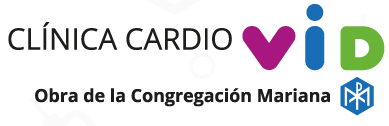

In [ ]:
# @title Execute Inference Interface  👇 {"run":"auto","vertical-output":true,"display-mode":"form"}
import subprocess
Opcion = "Principal menu" # @param ["Principal menu","Ayuda"]
LLave_ngrok ="2pzkgtgRVyLtoHzzsQ1UiXgfiYw_5A7bjJiBp65wYjh2S5VJm" # @param {"type":"string","placeholder":"Ingrese llave"}
Link_drive = "https://drive.google.com/drive/folders/1-QuTDp2CJUPr6VOde3ByuAldEvegyL-z?usp=drive_link" # @param {"type":"string","placeholder":"Ingrese enlace de la carpeta de google drive que desea cargar"}
Menu.update_key(LLave_ngrok)
Menu.update_link(Link_drive)
for boton in lista_botones:
    boton.menu_button = Menu
if(Opcion=="Principal menu"):
  Menu.MenuOne()
else:
  Menu.MenuTwo()

